### 2识别数字序列的卷积神经网络

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

% matplotlib inline

In [10]:
pickle_file = 'svhn_multi_train.pickle'
VALID_SIZE = int(500 / 2)

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = dataset['dataset'][VALID_SIZE:]
    train_labels = dataset['labels'][VALID_SIZE:, 1:6]
    valid_dataset = dataset['dataset'][:VALID_SIZE]
    valid_labels = dataset['labels'][:VALID_SIZE, 1:6]
    
print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)

Training dataset shape:  (33152, 40, 40)
Training labels shape:  (33152, 5)
Validing dataset shape:  (250, 40, 40)
Validing labels shape:  (250, 5)


In [11]:
pickle_file = 'svhn_multi_extra.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = np.vstack((train_dataset, dataset['dataset'][VALID_SIZE:170000]))
    train_labels = np.vstack((train_labels, dataset['labels'][VALID_SIZE:170000, 1:6]))
    valid_dataset = np.vstack((valid_dataset, dataset['dataset'][:VALID_SIZE]))
    valid_labels = np.vstack((valid_labels, dataset['labels'][:VALID_SIZE, 1:6]))
    
print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)    

Training dataset shape:  (202902, 40, 40)
Training labels shape:  (202902, 5)
Validing dataset shape:  (500, 40, 40)
Validing labels shape:  (500, 5)


In [12]:
train_labels[:10]

array([[ 7,  6, 10, 10, 10],
       [ 3,  7,  0, 10, 10],
       [ 1,  9, 10, 10, 10],
       [ 3,  5, 10, 10, 10],
       [ 9,  3, 10, 10, 10],
       [ 2,  8, 10, 10, 10],
       [ 1,  1, 10, 10, 10],
       [ 5,  6, 10, 10, 10],
       [ 5, 10, 10, 10, 10],
       [ 3,  6, 10, 10, 10]], dtype=int8)

In [13]:
IMAGE_SIZE = 40
NUM_DIGITS = 5
NUM_LABELS = 11 # 0-9 + 10==doesn't exist
NUM_CHANNELS = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
    #labels = (np.array([10,1,2,3,4,5,6,7,8,9]) == labels).astype(np.float32) # one-hot encoding

    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)


print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (202902, 40, 40, 1) (202902, 5)
Validation set (500, 40, 40, 1) (500, 5)


In [14]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 24
DEPTH_2 = 48
DEPTH_3 = 80
NUM_HIDDEN = 128
SEED = 42

In [15]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None, NUM_DIGITS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.int64)
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1), name='conv1_weights')
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]), name='conv1_biases')
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1), name='conv2_weights')
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]), name='conv2_biases')
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1), name='conv3_weights')
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]), name='conv3_biases')
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1), name='fc1_weights')
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]), name='fc1_biases')
    
    #fc_numdigit_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, MAX_NUM_DIGIT], stddev=0.1))
    #fc_numdigit_biases = tf.Variable(tf.constant(1.0, shape=[MAX_NUM_DIGIT]))
    fc_digit1_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit1_weights')
    fc_digit1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit1_biases')
    fc_digit2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit2_weights')
    fc_digit2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit2_biases')
    fc_digit3_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit3_weights')
    fc_digit3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit3_biases')
    fc_digit4_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit4_weights')
    fc_digit4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit4_biases')
    fc_digit5_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1), name='fc_digit5_weights')
    fc_digit5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='fc_digit5_biases')
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        
        if train:
            hidden = tf.nn.dropout(hidden, 0.8, seed=SEED)
            
        #logit_numdigit = tf.matmul(hidden, fc_numdigit_weights) + fc_numdigit_biases
        logit_digit1 = tf.matmul(hidden, fc_digit1_weights) + fc_digit1_biases
        logit_digit2 = tf.matmul(hidden, fc_digit2_weights) + fc_digit2_biases
        logit_digit3 = tf.matmul(hidden, fc_digit3_weights) + fc_digit3_biases
        logit_digit4 = tf.matmul(hidden, fc_digit4_weights) + fc_digit4_biases
        logit_digit5 = tf.matmul(hidden, fc_digit5_weights) + fc_digit5_biases
        
        return logit_digit1, logit_digit2, logit_digit3, logit_digit4, logit_digit5
    
    def predict(logits):
        return tf.transpose(tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                        tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)]))
        # return tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                       # tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)], axis=1)
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.reduce_all(tf.equal(predictions, labels), reduction_indices=1), tf.float32)) * 100
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:, 0])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:, 1])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:, 2])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:, 3])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:, 4]))
    
    regularizers = tf.nn.l2_loss(fc1_weights) + \
                tf.nn.l2_loss(fc_digit1_weights) + \
                tf.nn.l2_loss(fc_digit2_weights) + \
                tf.nn.l2_loss(fc_digit3_weights) + \
                tf.nn.l2_loss(fc_digit4_weights) + \
                tf.nn.l2_loss(fc_digit5_weights)
                
    loss += 1e-3 * regularizers
    
    batch = tf.Variable(0, dtype=tf.float32)
    #decayed_learning_rate = learning_rate *
    #                    decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(
        0.04, # Base learning rate
        batch * BATCH_SIZE, # Current index into the dataset
        train_labels.shape[0], # Decay step
        0.9, # Decay rate,
        staircase=True
    )
    
    optimizer = tf.train.AdagradOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    train_prediction = predict(logits)
    valid_prediction = predict(model(tf_valid_dataset))
    
    #tf.Print(train_prediction, [train_prediction])
    
    train_accuracy = accuracy(train_prediction, tf_train_labels)
    valid_accuracy = accuracy(valid_prediction, tf_valid_labels)

In [16]:
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_boolean('training', True, 'If true do the training else load already trained model.')
flags.DEFINE_string('checkpoint_dir', 'model/', 'Checkpoint directory')

In [17]:
import time
import datetime

NUM_STEPS = 30001
SHOW_STATE_AFTER = 500

train_accuracies = []
valid_accuracies = []

start_time = time.time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    offset = 0
    for step in range(NUM_STEPS):
        if(offset == 0):
            train_dataset, train_labels = shuffle_in_unison_inplace(train_dataset, train_labels)
            print('Random shuffle')
        feed_dict = {
            tf_train_dataset : train_dataset[offset:(offset + BATCH_SIZE)], 
            tf_train_labels : train_labels[offset:(offset + BATCH_SIZE)]
        }
        offset += BATCH_SIZE
        if offset+BATCH_SIZE > train_labels.shape[0]:
            offset = 0
        _, l, lr = session.run([optimizer, loss, learning_rate], feed_dict=feed_dict)
        if (step % SHOW_STATE_AFTER == 0):
            train_acc, valid_acc = session.run([train_accuracy, valid_accuracy], feed_dict=feed_dict)
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print('Minibatch loss at step %d: %f, learning rate: %.6f, %.3fs' % (step, l, lr, elapsed_time))
            train_accuracies.append(train_acc)
            print('Minibatch accuracy: %.1f%%' % train_accuracies[-1])
            valid_accuracies.append(valid_acc)
            print('Validation accuracy: %.1f%%' % valid_accuracies[-1])
    saver.save(session, 'multi.ckpt', write_meta_graph=False)
    #predictions = test_prediction.eval()
    #print('Test accuracy: %.1f%%' % test_accuracy.eval())

Initialized
Random shuffle
Minibatch loss at step 0: 64.269798, learning rate: 0.040000, 1.590s
Minibatch accuracy: 0.0%
Validation accuracy: 0.0%
Minibatch loss at step 500: 4.351222, learning rate: 0.040000, 12.170s
Minibatch accuracy: 31.2%
Validation accuracy: 21.8%
Minibatch loss at step 1000: 2.781978, learning rate: 0.040000, 12.152s
Minibatch accuracy: 65.6%
Validation accuracy: 43.0%
Minibatch loss at step 1500: 2.549631, learning rate: 0.040000, 12.139s
Minibatch accuracy: 68.8%
Validation accuracy: 53.6%
Minibatch loss at step 2000: 2.672587, learning rate: 0.040000, 12.153s
Minibatch accuracy: 68.8%
Validation accuracy: 59.4%
Minibatch loss at step 2500: 2.393546, learning rate: 0.040000, 12.153s
Minibatch accuracy: 75.0%
Validation accuracy: 64.2%
Minibatch loss at step 3000: 1.552931, learning rate: 0.040000, 12.140s
Minibatch accuracy: 85.9%
Validation accuracy: 62.0%
Random shuffle
Minibatch loss at step 3500: 1.249791, learning rate: 0.038000, 12.726s
Minibatch accurac

### 学习曲线

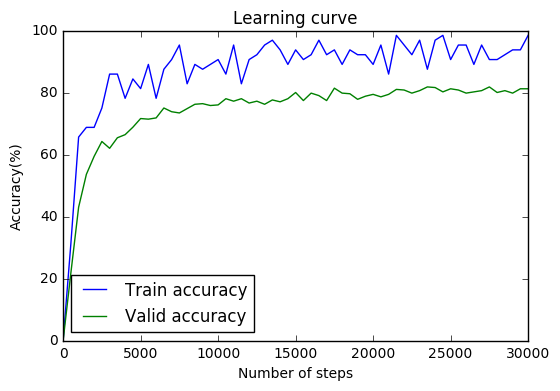

In [18]:
plt.plot(range(0, NUM_STEPS, SHOW_STATE_AFTER), train_accuracies)
plt.plot(range(0, NUM_STEPS, SHOW_STATE_AFTER), valid_accuracies)
plt.title('Learning curve')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy(%)')
plt.legend(['Train accuracy', 'Valid accuracy'], loc='best')

### Retraining